# YOLOv5 Model with Robinson Compass Edge Detection

## Data Acquistion

1. Import necessarly libraries
2. Use the kagglehub library to download the dataset
3. Move the dataset from default download location to current woring directory

In [1]:
import json
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from tqdm import tqdm
import yaml

In [2]:
import kagglehub

path = kagglehub.dataset_download(
    "kailaspsudheer/sarscope-unveiling-the-maritime-landscape" # Specify current working directory as the download path
)

print("Path to dataset files:", path)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/kailaspsudheer/sarscope-unveiling-the-maritime-landscape/versions/2


In [3]:
def move_contents_to_cwd(source_path):
    cwd = os.getcwd()
    
    items = os.listdir(source_path)
    
    for item in items:
        source_item_path = os.path.join(source_path, item)
        destination_path = os.path.join(cwd, item)
        
        if os.path.exists(destination_path):
            print(f"Warning: {item} already exists in destination, skipping.")
            continue
            
        if os.path.isdir(source_item_path):
            shutil.copytree(source_item_path, destination_path)
            shutil.rmtree(source_item_path)
            print(f"Moved directory: {item}")
        else:
            shutil.move(source_item_path, destination_path)
            print(f"Moved file: {item}")
    
    print(f"Successfully moved all contents from {source_path} to {cwd}")

move_contents_to_cwd(path)

Successfully moved all contents from /home/ubuntu/.cache/kagglehub/datasets/kailaspsudheer/sarscope-unveiling-the-maritime-landscape/versions/2 to /home/ubuntu


## Data Preparation
There are two primary steps for the data preparation in this model. First, we will need to convert the coco annotation data to YOLO format. Second, we will define the functionality for demonstrate the Robinson compass mask on sample images.

### Image Annotations
I referenced my teammate Jafar's code to handle the coco annotation data, as seen in src/yolo/yolov.ipynb
1. From working with the dataset, we learned that image #3736 is a corrupted image, so we want to remove it from the data set
2. Load the coco annotation data
3. Clean the coco annotation data
4. Convert coco image annotations to YOLO format

In [4]:
dataset_split = 'train'  # or 'train', 'valid' if needed
base_dir = f'./SARscope/{dataset_split}'
annotation_file = os.path.join(base_dir, '_annotations.coco.json') 
image_dir = base_dir  

# This is a known corrupted image ID, want to exclude it from the data
faulty_image_id = 3736

# Loading annotation data
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

faulty_image = next((img for img in coco_data['images'] if img['id'] == faulty_image_id), None)

if faulty_image:
    faulty_filename = faulty_image['file_name']
    image_path = os.path.join(image_dir, faulty_filename)

    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"✅ Removed image file: {faulty_filename}")
    else:
        print(f"⚠️ Image file not found: {faulty_filename}")

    # Removing image entry and related annotations from JSON
    coco_data['images'] = [img for img in coco_data['images'] if img['id'] != faulty_image_id]
    coco_data['annotations'] = [ann for ann in coco_data['annotations'] if ann['image_id'] != faulty_image_id]

    # Save updated annotations
    with open(annotation_file, 'w') as f:
        json.dump(coco_data, f)

    print("✅ Annotation file cleaned.")
else:
    print("⚠️ Image ID 3736 not found in annotations.")


⚠️ Image ID 3736 not found in annotations.


In [5]:
# --- Adjusting paths ---
splits = ['train', 'valid', 'test']
base_path = "./SARscope"

for split in splits:
    print(f"🛠️ Converting annotations for: {split}")

    json_path = os.path.join(base_path, split, "_annotations.coco.json")
    image_dir = os.path.join(base_path, split)
    labels_dir = os.path.join(base_path, split, "labels")

    # label folder
    os.makedirs(labels_dir, exist_ok=True)

    with open(json_path) as f:
        data = json.load(f)

    # lookup tables
    images = {img['id']: img['file_name'] for img in data['images']}
    annotations = {}
    for ann in data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations:
            annotations[image_id] = []
        annotations[image_id].append(ann)

    # Converting each image's annotations to YOLO format
    for image_id, file_name in tqdm(images.items()):
        width = height = 640  # Your dataset uses resized 640x640 images
        label_path = os.path.join(labels_dir, file_name.replace('.jpg', '.txt'))

        with open(label_path, "w") as f:
            for ann in annotations.get(image_id, []):
                x, y, w, h = ann['bbox']
                xc = (x + w / 2) / width
                yc = (y + h / 2) / height
                w /= width
                h /= height
                class_id = ann['category_id'] - 1  # YOLO requires class_id starting from 0
                f.write(f"{class_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

    print(f"✅ Finished converting {split}.")

🛠️ Converting annotations for: train


100%|██████████| 4716/4716 [00:00<00:00, 14198.11it/s]


✅ Finished converting train.
🛠️ Converting annotations for: valid


100%|██████████| 1346/1346 [00:00<00:00, 13919.79it/s]


✅ Finished converting valid.
🛠️ Converting annotations for: test


100%|██████████| 672/672 [00:00<00:00, 11366.45it/s]

✅ Finished converting test.


### Robinson Compass Masking
1. Define functions to apply Robinson compass mask to images
2. Visualize sample images before and after masks application
3. Visualize each of the eight directions being applied on one image
4. Apply Robinson Compass Masking to dataset with variable weighted

In [6]:
def create_robinson_compass_masks():
    """
    Create Robinson Compass masks for all 8 directions (N, NE, E, SE, S, SW, W, NW)
    Robinson masks use combinations of 0, 1, and 2 values for directional edge detection
    """
    # Define the 8 Robinson Compass masks
    robinson_masks = {
        'North': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
        'North-East': np.array([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]]),
        'East': np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]),
        'South-East': np.array([[2, 1, 0], [1, 0, -1], [0, -1, -2]]),
        'South': np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]),
        'South-West': np.array([[0, -1, -2], [1, 0, -1], [2, 1, 0]]),
        'West': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
        'North-West': np.array([[-2, -1, 0], [-1, 0, 1], [0, 1, 2]])
    }
    
    return robinson_masks


In [7]:
def apply_robinson_edge_detection(image, masks):
    """
    Apply all Robinson Compass masks to an image and combine the results
    
    Args:
        image: Grayscale input image
        masks: Dictionary of Robinson Compass masks
        
    Returns:
        combined_edges: Combined edge detection result
        direction_responses: Dictionary of edge responses in each direction
    """
    if len(image.shape) > 2:
        # Convert to grayscale if the image is in color
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
        
    # Initialize combined edge map
    combined_edges = np.zeros_like(gray_image, dtype=np.float32)
    direction_responses = {}
    
    # Apply each compass mask
    for direction, mask in masks.items():
        # Apply convolution
        response = cv2.filter2D(gray_image, cv2.CV_32F, mask)
        
        # Take absolute value to get edge strength regardless of direction
        response_abs = np.abs(response)
        
        # Store the directional response
        direction_responses[direction] = response_abs
        
        # Add to combined edges
        combined_edges = np.maximum(combined_edges, response_abs)
    
    # Normalize to 0-255 range for visualization
    combined_edges = cv2.normalize(combined_edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return combined_edges, direction_responses

In [8]:

def apply_edge_detection_to_dataset(image_paths, num_samples=5, output_dir="edge_detection_results"):
    """
    Apply Robinson Compass edge detection to a sample of images from the dataset
    and save the results
    
    Args:
        image_paths: List of image paths
        num_samples: Number of random samples to process
        output_dir: Directory to save the results
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create Robinson Compass masks
    robinson_masks = create_robinson_compass_masks()
    
    # Select random samples
    if len(image_paths) > num_samples:
        sample_paths = random.sample(image_paths, num_samples)
    else:
        sample_paths = image_paths
    
    results = []
    
    for img_path in tqdm(sample_paths, desc="Processing images"):
        # Read image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not read image {img_path}")
            continue
            
        # Apply Robinson edge detection
        edges, _ = apply_robinson_edge_detection(image, robinson_masks)
        
        # Save the result and original for comparison
        base_name = os.path.basename(img_path)
        output_path = os.path.join(output_dir, f"edge_{base_name}")
        cv2.imwrite(output_path, edges)
        
        # Store results for later visualization
        results.append({
            'original_path': img_path,
            'edge_path': output_path,
            'original': image,
            'edges': edges
        })
        
    return results

In [9]:
# Apply edge detection to a sample of images
all_image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) 
                      if fname.endswith(('.jpg', '.jpeg', '.png')) and not fname.startswith('_')]

results = apply_edge_detection_to_dataset(all_image_paths, num_samples=5)

Processing images: 100%|██████████| 5/5 [00:00<00:00, 53.92it/s]


In [10]:
def visualize_edge_detection_results(results):
    """
    Visualize edge detection results side by side with original images
    
    Args:
        results: List of dictionaries containing original and edge-detected images
    """
    num_results = len(results)
    if num_results == 0:
        print("No results to visualize")
        return
        
    # Create a figure with subplots
    fig, axes = plt.subplots(num_results, 2, figsize=(12, 4 * num_results))
    
    # Handle case with only one result
    if num_results == 1:
        axes = [axes]
        
    for i, result in enumerate(results):
        # Display original image
        axes[i][0].imshow(cv2.cvtColor(result['original'], cv2.COLOR_BGR2RGB))
        axes[i][0].set_title(f"Original Image")
        axes[i][0].axis('off')
        
        # Display edge detection result
        axes[i][1].imshow(result['edges'], cmap='gray')
        axes[i][1].set_title(f"Robinson Compass Edge Detection")
        axes[i][1].axis('off')
    
    plt.tight_layout()
    plt.savefig('robinson_edge_detection_comparison.png', dpi=300)
    plt.show()

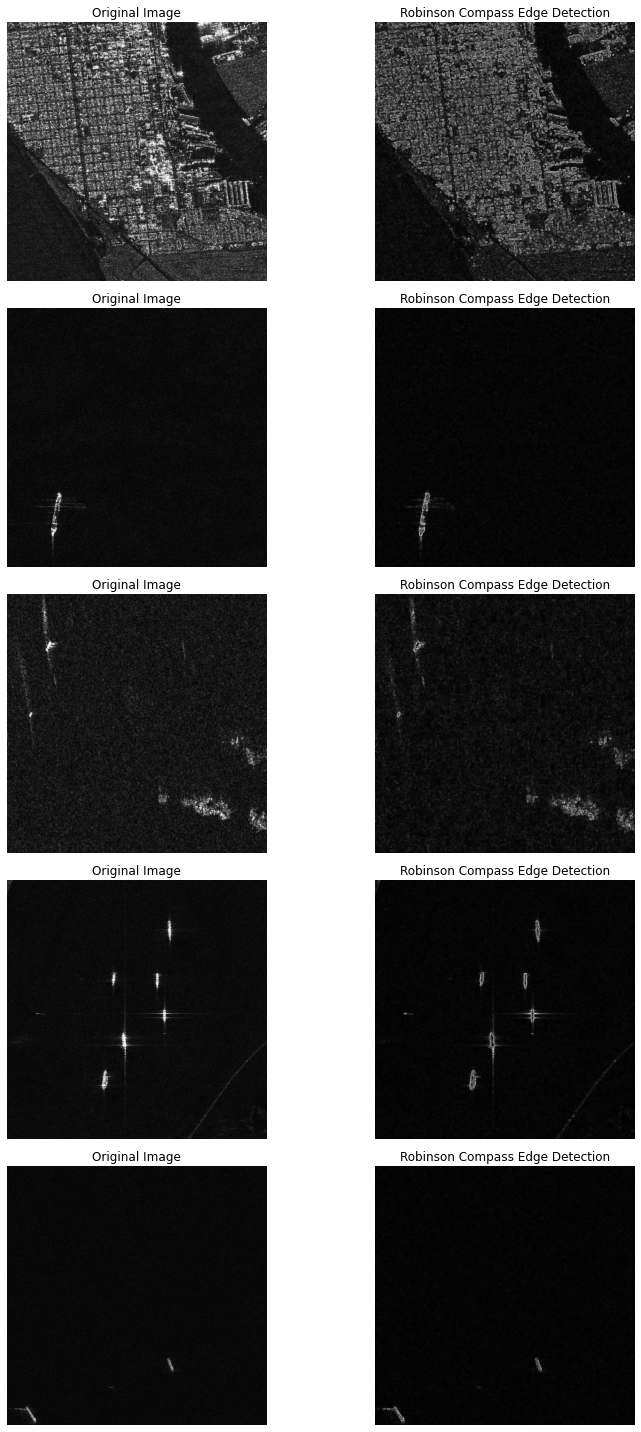

In [11]:
visualize_edge_detection_results(results)

In [12]:
def visualize_directional_responses(image_path):
    """
    Visualize edge detection in each of the 8 compass directions
    
    Args:
        image_path: Path to the image to process
    """
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return
    
    # Create Robinson Compass masks
    robinson_masks = create_robinson_compass_masks()
    
    # Apply Robinson edge detection
    _, direction_responses = apply_robinson_edge_detection(image, robinson_masks)
    
    # Create a figure with subplots for each direction
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    # Display original image in the center
    axes[1][1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[1][1].set_title("Original Image")
    axes[1][1].axis('off')
    
    # Define positions for each direction in the 3x3 grid
    positions = {
        'North-West': (0, 0),
        'North': (0, 1),
        'North-East': (0, 2),
        'West': (1, 0),
        # Center position (1,1) is for the original image
        'East': (1, 2),
        'South-West': (2, 0),
        'South': (2, 1),
        'South-East': (2, 2)
    }
    
    # Display each directional response
    for direction, pos in positions.items():
        if direction in direction_responses:
            axes[pos[0]][pos[1]].imshow(direction_responses[direction], cmap='hot')
            axes[pos[0]][pos[1]].set_title(direction)
            axes[pos[0]][pos[1]].axis('off')
    
    plt.tight_layout()
    plt.savefig('robinson_directional_responses.png', dpi=300)
    plt.show()

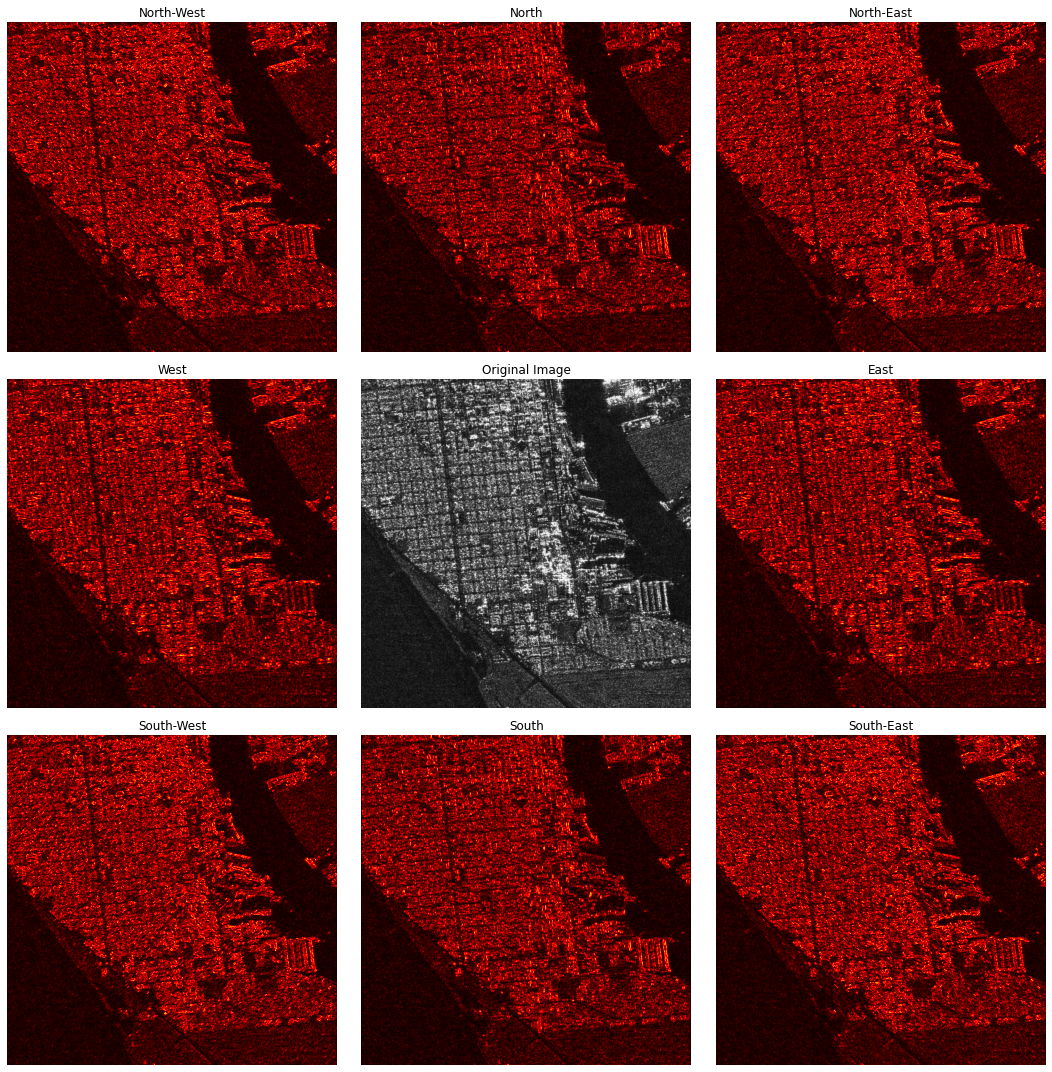

In [13]:
if results:
    visualize_directional_responses(results[0]['original_path'])

In [14]:
def prepare_edge_enhanced_images(edge_weight=0.5, output_dir='edge_enhanced_dataset'):
    """
    Prepare edge-enhanced images by combining original images with Robinson edge detection
    
    Args:
        edge_weight: Weight of edge map in the combined image (0.0 to 1.0)
        output_dir: Directory to save the edge-enhanced images
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create Robinson Compass masks
    robinson_masks = create_robinson_compass_masks()
    
    # Get all image paths
    all_image_paths = [os.path.join(base_dir, fname) for fname in os.listdir(base_dir) 
                      if fname.endswith(('.jpg', '.jpeg', '.png')) and not fname.startswith('_')]
    
    print(f"Processing {len(all_image_paths)} images...")
    
    for img_path in tqdm(all_image_paths):
        # Read image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not read image at {img_path}")
            continue
        
        # Apply Robinson edge detection
        edges, _ = apply_robinson_edge_detection(image, robinson_masks)
        
        # Create colored edge map (for visualization)
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        
        # Blend original image with edge map
        enhanced_image = cv2.addWeighted(image, 1.0, edges_colored, edge_weight, 0)
        
        # Save enhanced image
        output_path = os.path.join(output_dir, os.path.basename(img_path))
        cv2.imwrite(output_path, enhanced_image)
    
    # Copy annotation files
    annotation_files = [fname for fname in os.listdir(base_dir) if fname.startswith('_')]
    for ann_file in annotation_files:
        src_path = os.path.join(base_dir, ann_file)
        dst_path = os.path.join(output_dir, ann_file)
        shutil.copy(src_path, dst_path)
    
    print(f"Edge-enhanced dataset created at {output_dir}")
    return output_dir

In [15]:
edge_enhanced_dir = prepare_edge_enhanced_images(edge_weight=0.5)

Processing 4716 images...


100%|██████████| 4716/4716 [01:12<00:00, 65.25it/s]

Edge-enhanced dataset created at edge_enhanced_dataset


In [16]:
def visualize_original_vs_enhanced(num_samples=3):
    """
    Visualize comparison between original and edge-enhanced images
    """
    # Get original and enhanced image paths
    original_paths = [os.path.join(base_dir, fname) for fname in os.listdir(base_dir) 
                     if fname.endswith(('.jpg', '.jpeg', '.png')) and not fname.startswith('_')]
    enhanced_paths = [os.path.join(edge_enhanced_dir, fname) for fname in os.listdir(edge_enhanced_dir) 
                     if fname.endswith(('.jpg', '.jpeg', '.png')) and not fname.startswith('_')]
    
    # Match filenames
    original_dict = {os.path.basename(p): p for p in original_paths}
    enhanced_dict = {os.path.basename(p): p for p in enhanced_paths}
    
    # Find common files
    common_files = list(set(original_dict.keys()) & set(enhanced_dict.keys()))
    
    if len(common_files) > num_samples:
        sample_files = random.sample(common_files, num_samples)
    else:
        sample_files = common_files
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 2, figsize=(14, 5 * num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, filename in enumerate(sample_files):
        # Read original image
        original_img = cv2.imread(original_dict[filename])
        
        # Read enhanced image
        enhanced_img = cv2.imread(enhanced_dict[filename])
        
        # Display original image
        axes[i, 0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f"Original Image")
        axes[i, 0].axis('off')
        
        # Display enhanced image
        axes[i, 1].imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
        axes[i, 1].set_title(f"Edge-Enhanced Image")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('original_vs_enhanced_comparison.png', dpi=300)
    plt.show()

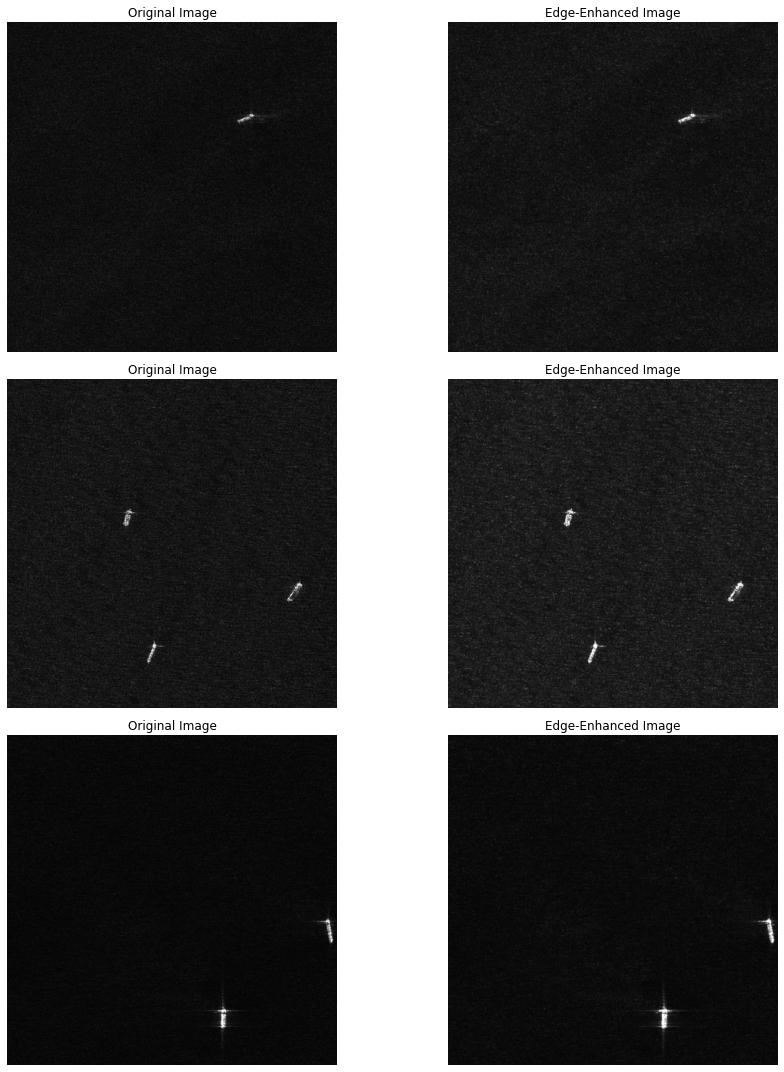

In [17]:
visualize_original_vs_enhanced(num_samples=3)

## YOLOv5 Model Training

In [18]:
def prepare_yolov5_dataset(source_dir, output_dir='yolov5_dataset'):
    """
    Convert COCO annotations to YOLOv5 format
    
    Args:
        source_dir: Directory containing images and COCO annotations
        output_dir: Directory to save YOLOv5 format dataset
    """
    # Create output directory structure
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)
    
    # Load COCO annotations
    coco_file = os.path.join(source_dir, '_annotations.coco.json')
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)
    
    # Create id to category name mapping
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Create category name to index mapping (zero-indexed)
    category_indices = {cat['name']: i for i, cat in enumerate(coco_data['categories'])}
    
    # Create image id to file name mapping
    image_map = {img['id']: img for img in coco_data['images']}
    
    # Save the classes file
    with open(os.path.join(output_dir, 'classes.txt'), 'w') as f:
        for cat in coco_data['categories']:
            f.write(f"{cat['name']}\n")
    
    # Group annotations by image id
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)
    
    # Process each image
    for image_id, annotations in annotations_by_image.items():
        if image_id not in image_map:
            continue
            
        image_info = image_map[image_id]
        image_file = image_info['file_name']
        image_width = image_info['width']
        image_height = image_info['height']
        
        # Copy image to YOLOv5 directory
        src_path = os.path.join(source_dir, image_file)
        dst_path = os.path.join(output_dir, 'images', image_file)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Warning: Image file not found: {src_path}")
            continue
        
        # Create YOLO format annotation file
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(output_dir, 'labels', label_file)
        
        with open(label_path, 'w') as f:
            for ann in annotations:
                # Get category
                category_id = ann['category_id']
                category_name = categories[category_id]
                category_index = category_indices[category_name]
                
                # Get bounding box in COCO format (x, y, width, height)
                bbox = ann['bbox']
                x, y, w, h = bbox
                
                # Convert to YOLOv5 format (x_center, y_center, width, height) normalized
                x_center = (x + w/2) / image_width
                y_center = (y + h/2) / image_height
                w_norm = w / image_width
                h_norm = h / image_height
                
                # Write to file
                f.write(f"{category_index} {x_center} {y_center} {w_norm} {h_norm}\n")
    
    # Create dataset.yaml file for YOLOv5
    yaml_content = {
        'path': os.path.abspath(output_dir),
        'train': 'images',
        'val': 'images',  # Assume same images for validation in this example
        'nc': len(categories),
        'names': [categories[i] for i in sorted(categories.keys())]
    }
    
    with open(os.path.join(output_dir, 'dataset.yaml'), 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)
    
    print(f"YOLOv5 dataset prepared at {output_dir}")
    return output_dir

In [19]:
# Prepare YOLOv5 dataset from edge-enhanced images
yolov5_dataset_dir = prepare_yolov5_dataset(edge_enhanced_dir)

YOLOv5 dataset prepared at yolov5_dataset


In [70]:
print(yolov5_dataset_dir)

yolov5_dataset


In [25]:
# Code to train YOLOv5 model (commented out - uncomment to run)

# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5

# Install requirements
!pip install -r yolov5/requirements.txt

# Train YOLOv5 model on edge-enhanced images
!cd yolov5 && python train.py --data {os.path.abspath(os.path.join(yolov5_dataset_dir, 'dataset.yaml'))} --weights yolov5s.pt --epochs 100 --batch-size 16 --img 640 --name edge_enhanced_model


fatal: destination path 'yolov5' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/ubuntu/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
2025-04-30 07:06:35.259896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745996795.487886    8032 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745996795.583005    8032 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



                 Class     Images  Instances          P          R      mAP50   
                   all       4716      13640      0.937      0.883      0.946      0.657

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
  0%|          | 0/295 [00:00<?, ?it/s]/home/ubuntu/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      55/99      4.51G    0.02149   0.006935          0         44        640:  /home/ubuntu/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      55/99      4.51G    0.02547   0.006425          0         37        640:  /home/ubuntu/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



                 Class     Images  Instances          P          R      mAP50   
                   all       4716      13640      0.947      0.903      0.957      0.693

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
  0%|          | 0/295 [00:00<?, ?it/s]/home/ubuntu/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      82/99      4.51G    0.02428   0.008194          0         52        640:  /home/ubuntu/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      82/99      4.51G    0.02755    0.01055          0        115        640:  /home/ubuntu/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with 

In [26]:
def display_dataset_summary():
    """
    Display summary statistics about the dataset and edge-enhancement process
    """
    # Count original images
    original_count = len([f for f in os.listdir(base_dir) 
                        if f.endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('_')])
    
    # Count enhanced images
    enhanced_count = len([f for f in os.listdir(edge_enhanced_dir) 
                        if f.endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('_')])
    
    # Get annotation statistics
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)
    
    num_categories = len(coco_data['categories'])
    category_names = [cat['name'] for cat in coco_data['categories']]
    num_annotations = len(coco_data['annotations'])
    
    # Count annotations per category
    annotations_per_category = {}
    for ann in coco_data['annotations']:
        cat_id = ann['category_id']
        cat_name = next((cat['name'] for cat in coco_data['categories'] if cat['id'] == cat_id), 'Unknown')
        if cat_name not in annotations_per_category:
            annotations_per_category[cat_name] = 0
        annotations_per_category[cat_name] += 1
    
    # Print summary
    print("\n---- Dataset Summary ----")
    print(f"Total images: {original_count}")
    print(f"Edge-enhanced images: {enhanced_count}")
    print(f"Number of categories: {num_categories}")
    print(f"Category names: {', '.join(category_names)}")
    print(f"Total annotations: {num_annotations}")

In [27]:
display_dataset_summary()


---- Dataset Summary ----
Total images: 4716
Edge-enhanced images: 4716
Number of categories: 1
Category names: ship
Total annotations: 13640

Annotations per category:
  - ship: 13640

---- Edge Enhancement Summary ----
Robinson Compass masks were applied in 8 directions
Edge weight in blended images: 0.5
Edge-enhanced dataset directory: edge_enhanced_dataset
YOLOv5 dataset directory: yolov5_dataset


## Visualizing Model Training Results 
I will be using the same visualizations as the other YOLOv5 models to make comparisons easier.
1. Load model results from training
2. Visualize training losses per epoch
3. Visualize validation metrics

In [35]:
def load_model_results(results_dir):
    """
    Load training results from YOLOv5 training output
    
    Args:
        results_dir: Directory containing training results
        
    Returns:
        results_data: Dictionary containing training metrics
    """
    # Load results.csv generated by YOLOv5
    results_file = os.path.join(results_dir, 'results.csv')
    if not os.path.exists(results_file):
        print(f"Results file not found at {results_file}")
        return None
    
    results_df = pd.read_csv(results_file)
    return results_df

In [45]:
results_df = load_model_results("./yolov5/runs/train/edge_enhanced_model/")
print(results_df.head())

                  epoch        train/box_loss        train/obj_loss  \
0                     0              0.088355              0.024095   
1                     1              0.057360              0.016490   
2                     2              0.052717              0.015075   
3                     3              0.048859              0.013597   
4                     4              0.044588              0.013094   

         train/cls_loss     metrics/precision        metrics/recall  \
0                     0               0.64496               0.49091   
1                     0               0.74112               0.65924   
2                     0               0.76936               0.67045   
3                     0               0.80364               0.67874   
4                     0               0.86302               0.76493   

        metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
0               0.53395               0.20218              0.051660   
1   

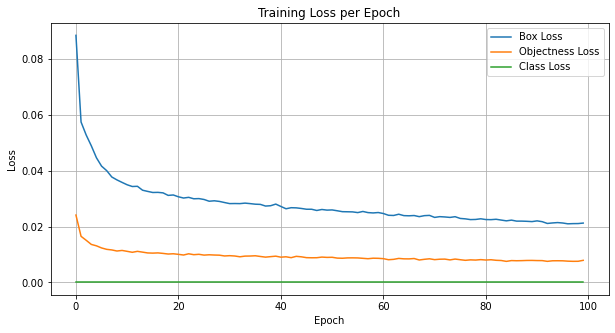

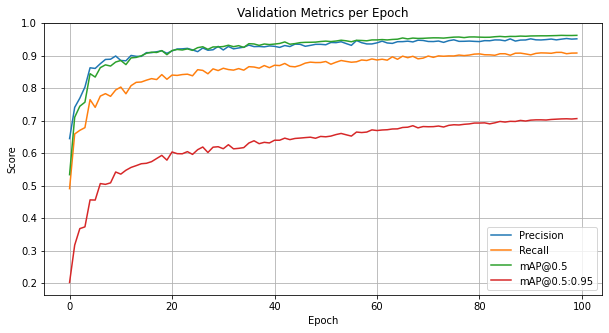

In [46]:
results_df.columns = results_df.columns.str.strip()

# Training Losses
plt.figure(figsize=(10, 5))
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Box Loss')
plt.plot(results_df['epoch'], results_df['train/obj_loss'], label='Objectness Loss')
plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Class Loss')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Validation Metrics
plt.figure(figsize=(10, 5))
plt.plot(results_df['epoch'], results_df['metrics/precision'], label='Precision')
plt.plot(results_df['epoch'], results_df['metrics/recall'], label='Recall')
plt.plot(results_df['epoch'], results_df['metrics/mAP_0.5'], label='mAP@0.5')
plt.plot(results_df['epoch'], results_df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
plt.title("Validation Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
print(results_df)

                   epoch        train/box_loss        train/obj_loss  \
0                      0              0.088355              0.024095   
1                      1              0.057360              0.016490   
2                      2              0.052717              0.015075   
3                      3              0.048859              0.013597   
4                      4              0.044588              0.013094   
..                   ...                   ...                   ...   
95                    95              0.021256              0.007737   
96                    96              0.020965              0.007612   
97                    97              0.021034              0.007553   
98                    98              0.021054              0.007565   
99                    99              0.021229              0.007906   

          train/cls_loss     metrics/precision        metrics/recall  \
0                      0               0.64496               0.

## Testing Model on Test Data

In [64]:
weights_path = './yolov5/runs/train/edge_enhanced_model/weights/best.pt'
test_images_path = './SARscope/test'
output_dir = './runs/test/edge_enhanced_model_predictions'
os.makedirs(output_dir, exist_ok=True)

In [65]:
!python ./yolov5/detect.py \
  --weights {weights_path} \
  --img 640 \
  --conf 0.25 \
  --source {test_images_path} \
  --project runs/test \
  --name edge_enhanced_model_predictions \
  --exist-ok

detect: weights=['./yolov5/runs/train/edge_enhanced_model/weights/best.pt'], source=./SARscope/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/test, name=edge_enhanced_model_predictions, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.10.12 torch-2.6.0 CUDA:0 (NVIDIA GH200 480GB, 96768MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/672 /home/ubuntu/SARscope/test/000003_jpg.rf.d35f1b3e7a2f971d5edb6bd95bdb0af4.jpg: 640x640 1 ship, 6.1ms
image 2/672 /home/ubuntu/SARscope/test/000047_jpg.rf.a7c5a75819459815e026bd5f7c0c5d3d.jpg: 640x640 2 ships, 7.2ms
image 3/672 /home/ubuntu/SARsc


Showing 2 sample detection results:
Image: P0070_3000_3800_2400_3200_png.rf.5665332b0950b194d205b5da3f819294.jpg


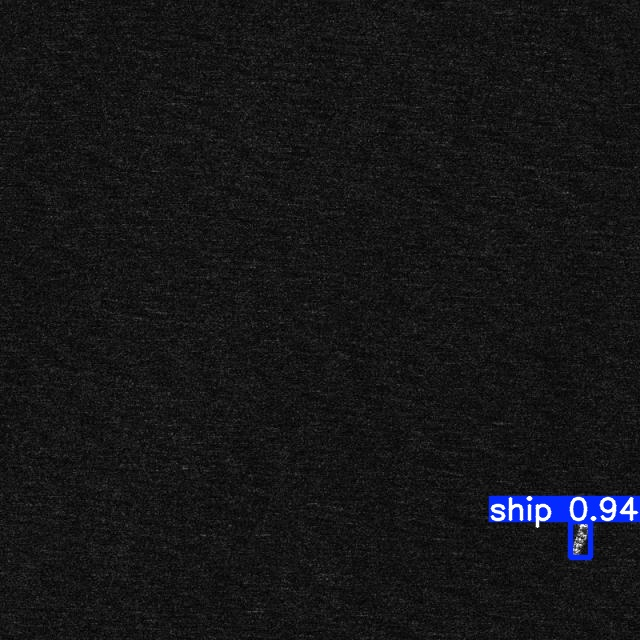

Image: P0084_600_1400_1800_2600_png.rf.e7a91bb11704d31bfe071086ea4b03c1.jpg


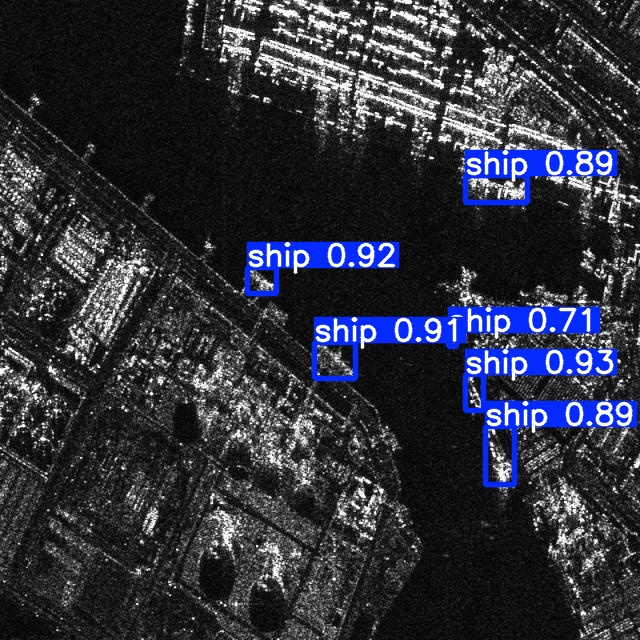

In [69]:
import glob
from IPython.display import Image, display
import random

# Find the output images
result_images = glob.glob(f"{output_dir}/*.jpg")

# Display a few random results
if result_images:
    sample_count = min(2, len(result_images))
    sample_images = random.sample(result_images, sample_count)
    
    print(f"\nShowing {sample_count} sample detection results:")
    for img_path in sample_images:
        print(f"Image: {os.path.basename(img_path)}")
        display(Image(img_path))
else:
    print("No result images found. Check the output directory.")